<a href="https://colab.research.google.com/github/grace3999/USV_Python/blob/colab/Notebooks/4_xr_Annotations_classification_8features.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mount google drive containings required files: 1) csv of annotation features, 2) netcdf files
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
!pip install netcdf4

     |████████████████████████████████| 4.1MB 5.0MB/s 
     |████████████████████████████████| 307kB 43.2MB/s 


In [3]:
!pip install seaborn==0.9.0

In [0]:
import numpy as np
import pandas as pd
import xarray as xr
import pickle

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score, cross_val_predict, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC  
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score
from sklearn.utils import resample

#visualizing results
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [0]:
#from sklearn code

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [0]:
features_path_CPA = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/finals/annot_8features_25noise_CPA.csv'
features_path_neutral = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/feature_data_frames/finals/annot_8features_25noise_neutral.csv'
features_path = [features_path_CPA, features_path_neutral]

In [6]:
annot_features_df = pd.DataFrame()

#Read in data frame of annotation features
for path in features_path:
  data = pd.read_csv(path)
  annot_features = pd.DataFrame(data = data)
  print(annot_features.shape)
  #check for missing values
  if annot_features.isnull().sum().sum() > 0:
    print('You have missing values in your data frame')
  else:
    print('Your data frame is complete')
  
  annot_features_df = annot_features_df.append(annot_features)

#clean up annotations etc
annot_features_df.dropna(axis=0, inplace=True)
annot_features_df.replace('low ', 'low', inplace=True)
annot_features_df.replace('BBC', 'bbc', inplace=True)
annot_features_df.replace('medium', 'mid', inplace=True)
annot_features_df.replace('low mulit', 'low multi', inplace=True)
print(annot_features_df.shape)
annot_features_df.head()

(930, 14)
Your data frame is complete
(528, 14)
Your data frame is complete
(1458, 14)


,Unnamed: 0,Annotation,animal_number,exp,power_sum,session,spec_cent,spec_kurt,spec_pur,spec_roll,spec_skew,spec_slope,spec_spread,time_stamp
0,0,low,533,cFos,32714.904,CPApost,40822.118664,26.730238,0.368722,38781.012731,4.407609,0.000149,14708.781584,46305.0
1,1,low,533,cFos,43037.465,CPApost,39223.520547,50.458618,0.306856,37262.344520,6.834279,-0.000471,60650.044678,149692.5
2,2,low,533,cFos,270193.530,CPApost,15682.487917,35.797254,0.062226,14898.363521,5.691443,-0.001451,22744.547200,243157.5
3,3,low multi,533,cFos,74933.164,CPApost,25651.770426,25.973715,0.206291,24369.181905,4.635655,-0.000857,12743.414031,295560.0
4,4,low,533,cFos,239525.480,CPApost,20638.202752,4.124133,0.082071,19606.292614,2.252369,-0.001831,17040.455086,337747.5


In [7]:
annot_features_df['Annotation'].value_counts()

rand_noise     1075
bbc             139
low             121
high             47
low multi        46
low complex      20
high multi        5
mid               5
Name: Annotation, dtype: int64

In [8]:
#create class column (noise = 0, USV = 1)
annot_features_df['class'] = np.where(annot_features_df['Annotation']=='rand_noise', 0, 1)
print(annot_features_df['class'].value_counts())

#create subsets of data based on experimental condition and/or session

#by session type
CPA_sessions = annot_features_df[annot_features_df['session'] == 'CPApost']
print('CPA_sessions', CPA_sessions.shape)

#no round 2 (very different background noise pattern)
noR2 = annot_features_df[annot_features_df['exp'] != 'round2']
print('no round 2', noR2.shape)
noR2_CPAonly = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['session'] == 'CPApost')]
print('noR2_CPAonly', noR2_CPAonly.shape)

low_and_noise = ['low', 'low multi', 'low complex', 'rand_noise']
lowonly = annot_features_df[annot_features_df['Annotation'].isin(low_and_noise)]
print('lowonly', lowonly.shape)
lowonly_noR2 = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['Annotation'].isin(low_and_noise))]
print('lowonly_noR2', lowonly_noR2.shape)
lowonly_CPAonly = annot_features_df[(annot_features_df['session'] != 'CPApost') & (annot_features_df['Annotation'].isin(low_and_noise))]
print('lowonly_CPAonly', lowonly_CPAonly.shape)

BBC_and_noise = ['bbc', 'rand_noise']
BBConly = annot_features_df[annot_features_df['Annotation'].isin(BBC_and_noise)]
print('BBConly', BBConly.shape)
BBConly_noR2 = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['Annotation'].isin(BBC_and_noise))]
print('BBConly_noR2', BBConly_noR2.shape)
BBConly_CPAonly = annot_features_df[(annot_features_df['session'] != 'CPApost') & (annot_features_df['Annotation'].isin(BBC_and_noise))]
print('BBConly_CPAonly', BBConly_CPAonly.shape)

high_and_noise = ['high', 'high multi', 'rand_noise']
highonly = annot_features_df[annot_features_df['Annotation'].isin(high_and_noise)]
print('highonly', highonly.shape)
highonly_noR2 = annot_features_df[(annot_features_df['exp'] != 'round2') & (annot_features_df['Annotation'].isin(high_and_noise))]
print('highonly_noR2', highonly_noR2.shape)
high_and_noise_CPAonly = annot_features_df[(annot_features_df['session'] != 'CPApost') & (annot_features_df['Annotation'].isin(high_and_noise))]
print('high_and_noise_CPAonly', high_and_noise_CPAonly.shape)

0    1075
1     383
Name: class, dtype: int64
CPA_sessions (930, 15)
no round 2 (818, 15)
noR2_CPAonly (549, 15)
lowonly (1262, 15)
lowonly_noR2 (715, 15)
lowonly_CPAonly (462, 15)
BBConly (1214, 15)
BBConly_noR2 (605, 15)
BBConly_CPAonly (458, 15)
highonly (1127, 15)
highonly_noR2 (593, 15)
high_and_noise_CPAonly (458, 15)


In [0]:
#upsampling code avaliable at end of notebook (did not improve model)
#annomaly detection code avaliable at end of notebook (did not improve model)

#separate and save for later testing dataset
train, test = train_test_split(annot_features_df, test_size=0.3, random_state=1, stratify = annot_features_df['Annotation'])

#separate and save features for train and test sets
train_features = train[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]
test_features = test[['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll']]

#separate and save class labels for train and test sets
train_class = train['class']
test_class = test['class']

#center and scale the data for train and test sets
scaler = StandardScaler()
train_features_scaled = scaler.fit_transform(train_features)
test_features_scaled = scaler.fit_transform(test_features)

#stratified kfold
strat_k_fold = StratifiedKFold(n_splits=3)
cv = list(strat_k_fold.split(train_features_scaled, train_class))

#instantiate models with balanced class weights
lr_cv = LogisticRegression(random_state=0, class_weight='balanced')
rf_cv = RandomForestClassifier(max_depth=10, random_state=0, class_weight='balanced')
svm_cv = SVC(probability=True, class_weight='balanced') 

In [29]:
y_pred_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_lr = cross_val_predict(lr_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_lr = confusion_matrix(train_class, y_pred_lr)
print(conf_mat_lr)
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_lr))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_lr))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_lr))
print("F1:", metrics.f1_score(train_class,y_pred_lr))

y_pred_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_rf = cross_val_predict(rf_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_rf = confusion_matrix(train_class, y_pred_rf)
print(conf_mat_rf)
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class, y_pred_rf))
print("Precision (PPV): ", metrics.precision_score(train_class, y_pred_rf))
print("Accuracy: ", metrics.accuracy_score(train_class, y_pred_rf))
print("F1:", metrics.f1_score(train_class, y_pred_rf))

y_pred_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict')
y_pred_prob_svm = cross_val_predict(svm_cv, train_features_scaled, train_class, cv=cv, method='predict_proba')
conf_mat_svm = confusion_matrix(train_class, y_pred_svm)
print(conf_mat_svm)
# calculate some of these metrics using sklearn and the test set samples
print("Sensitivity/Recall (TPR): ",metrics.recall_score(train_class,y_pred_svm))
print("Precision (PPV): ", metrics.precision_score(train_class,y_pred_svm))
print("Accuracy: ", metrics.accuracy_score(train_class,y_pred_svm))
print("F1:", metrics.f1_score(train_class,y_pred_svm))

print("Logistic regression ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_lr[:,1]))
print("Random forest ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_rf[:,1]))
print("SVM ROC_AUC: ", metrics.roc_auc_score(train_class, y_pred_prob_svm[:,1]))


[[429 323]
 [ 87 181]]
Sensitivity/Recall (TPR):  0.6753731343283582
Precision (PPV):  0.35912698412698413
Accuracy:  0.5980392156862745
F1: 0.4689119170984456
[[728  24]
 [ 88 180]]
Sensitivity/Recall (TPR):  0.6716417910447762
Precision (PPV):  0.8823529411764706
Accuracy:  0.8901960784313725
F1: 0.7627118644067797
[[664  88]
 [ 79 189]]
Sensitivity/Recall (TPR):  0.7052238805970149
Precision (PPV):  0.6823104693140795
Accuracy:  0.8362745098039216
F1: 0.6935779816513762
Logistic regression ROC_AUC:  0.7421899809463322
Random forest ROC_AUC:  0.8900444585582726
SVM ROC_AUC:  0.8704003255001588


In [27]:
#once you have decided on the model and hyperparameters, fit the model using the train data
lr_cv.fit(train_features_scaled, train_class) 
rf_cv.fit(train_features_scaled, train_class) 
svm_cv.fit(train_features_scaled, train_class)

#test model using test data and theshold of 0.5
print('Logistic regression test AUC: {}'.format(lr_cv.score(test_features_scaled, test_class)))
test_pred_lr = lr_cv.predict(test_features_scaled)
test_pred_prob_lr = lr_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_lr))
print(confusion_matrix(test_class, test_pred_lr))

#test model using test data and theshold of 0.5
print('Random forest test AUC: {}'.format(rf_cv.score(test_features_scaled, test_class)))
test_pred_rf = rf_cv.predict(test_features_scaled)
test_pred_prob_rf = rf_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_rf))
print(confusion_matrix(test_class, test_pred_rf))

#test model using test data and theshold of 0.5
print('SVM test AUC: {}'.format(svm_cv.score(test_features_scaled, test_class)))
test_pred_svm = svm_cv.predict(test_features_scaled)
test_pred_prob_svm = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
print(confusion_matrix(test_class, test_pred_svm))

#pickel model to save for later use
#save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


#pkl_filename = str(save_path + "trained_pickle_model_8features_rf_full_500noise_clean.pkl")  
#with open(pkl_filename, 'wb') as file:  
#    pickle.dump(rf_cv, file)
    
#pickel model to save for later use
#save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


#pkl_filename = str(save_path + "trained_pickle_model_8features_svm_full_500noise_clean.pkl")  
#with open(pkl_filename, 'wb') as file:  
#    pickle.dump(svm_cv, file)

Logistic regression test AUC: 0.5799086757990868
              precision    recall  f1-score   support

           0       0.83      0.54      0.66       323
           1       0.35      0.68      0.46       115

    accuracy                           0.58       438
   macro avg       0.59      0.61      0.56       438
weighted avg       0.70      0.58      0.60       438

[[176 147]
 [ 37  78]]
Random forest test AUC: 0.8333333333333334
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       323
           1       0.73      0.57      0.64       115

    accuracy                           0.83       438
   macro avg       0.80      0.75      0.77       438
weighted avg       0.83      0.83      0.83       438

[[299  24]
 [ 49  66]]
SVM test AUC: 0.8447488584474886
              precision    recall  f1-score   support

           0       0.90      0.89      0.89       323
           1       0.69      0.73      0.71       115

    accurac

Confusion matrix, without normalization
[[176 147]
 [ 37  78]]


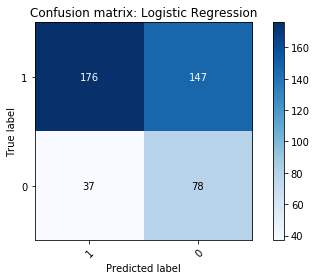

Confusion matrix, without normalization
[[299  24]
 [ 49  66]]


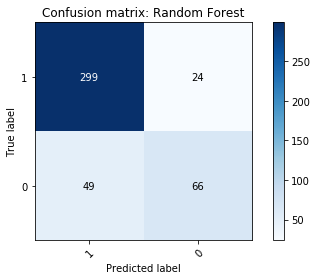

Confusion matrix, without normalization
[[286  37]
 [ 31  84]]


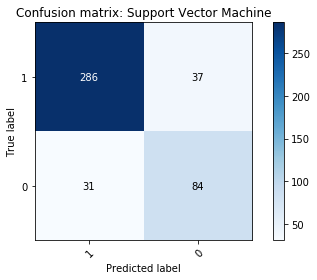

In [31]:
# Plot non-normalized confusion matrix
plot_confusion_matrix(test_class, test_pred_lr, classes=test_class, normalize=False,
                      title='Confusion matrix: Logistic Regression')



plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_class, test_pred_rf, classes=test_class, normalize=False,
                      title='Confusion matrix: Random Forest')



plt.show()

# Plot non-normalized confusion matrix
plot_confusion_matrix(test_class, test_pred_svm, classes=test_class, normalize=False,
                      title='Confusion matrix: Support Vector Machine')



plt.show()

Text(0, 0.5, 'True Positive Rate (Sensitivity)')

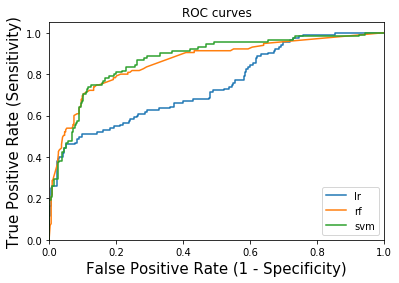

In [33]:
fpr_lr, tpr_lr, thresholds_lr = metrics.roc_curve(test_class, test_pred_prob_lr[:,1])
fpr_rf, tpr_rf, thresholds_rf = metrics.roc_curve(test_class, test_pred_prob_rf[:,1])
fpr_svm, tpr_svm, thresholds_svm = metrics.roc_curve(test_class, test_pred_prob_svm[:,1])
# plot LR model ROC curves
plt.plot(fpr_lr, tpr_lr,label="lr")
plt.plot(fpr_rf, tpr_rf,label="rf")
plt.plot(fpr_svm, tpr_svm,label="svm")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('ROC curves')
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize = 15)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize = 15)

Text(0, 0.5, 'Precision')

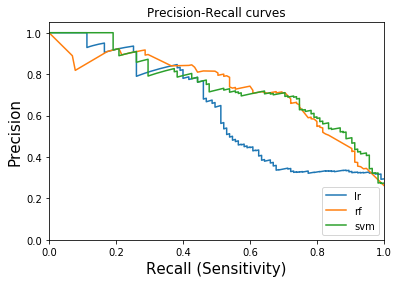

In [34]:
# calculate precision-recall curve
precision_lr, recall_lr, thresholds_pr_lr = metrics.precision_recall_curve(test_class, test_pred_prob_lr[:,1])
precision_rf, recall_rf, thresholds_pr_rf = metrics.precision_recall_curve(test_class, test_pred_prob_rf[:,1])
precision_svm, recall_svm, thresholds_pr_svm = metrics.precision_recall_curve(test_class, test_pred_prob_svm[:,1])

plt.plot(recall_lr, precision_lr, label='lr')
plt.plot(recall_rf, precision_rf, label='rf')
plt.plot(recall_svm, precision_svm, label='svm')

plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.title('Precision-Recall curves')
plt.legend(loc="lower right")
plt.xlabel('Recall (Sensitivity)', fontsize = 15)
plt.ylabel('Precision', fontsize = 15)

Text(0, 0.5, 'True Positive Rate (Sensitivity) or Class 1 Threshold Probability')

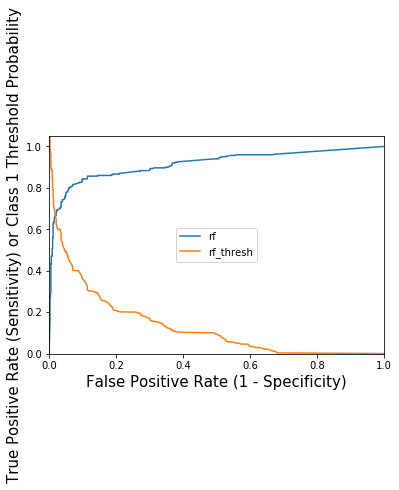

In [0]:
# plot best model with thresholds
plt.plot(fpr_rf, tpr_rf, label="rf")
plt.plot(fpr_rf, thresholds_rf, label="rf_thresh")
plt.xlim([0, 1])
plt.ylim([0, 1.05])
plt.legend(loc="center")
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize= 15)
plt.ylabel('True Positive Rate (Sensitivity) or Class 1 Threshold Probability', fontsize = 15)

In [0]:
#create new columns for each model's pred prob and the best model's pred class
train['pred_prob_lr'] = y_pred_prob_lr[:,1]
train['pred_prob_rf'] = y_pred_prob_rf[:,1]
train['pred_prob_svm'] = y_pred_prob_svm[:,1]
train['class_rf'] = y_pred_rf
train['class_svm'] = y_pred_svm
train.head()

,Unnamed: 0,Annotation,animal_number,exp,power_sum,session,spec_cent,spec_kurt,spec_pur,spec_roll,spec_skew,spec_slope,spec_spread,time_stamp,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm
409,84,rand_noise,542,cFos,84541.734,CPApost,40315.962633,52.611815,0.327263,38300.164501,7.038969,-0.000254,61631.969390,5647.5,0,0.460136,0.000000,0.145739,0,0
400,75,rand_noise,542,cFos,31247.270,CPApost,39531.964463,55.131566,0.249881,37555.366240,7.310696,-0.000994,175412.954223,94567.5,0,0.142518,0.100000,0.124985,0,0
783,458,rand_noise,624,round2,553420.700,CPApost,11609.180253,29.690861,0.050238,11028.721240,5.331486,-0.001303,17670.317018,153967.5,0,0.472132,0.186895,0.185164,0,0
808,483,rand_noise,626,round2,472564.280,CPApost,10573.316013,35.079846,0.031969,10044.650213,5.824241,-0.001362,22322.772556,241942.5,0,0.409240,0.000000,0.103478,0,0
335,10,rand_noise,533,cFos,34301.730,CPApost,34671.010064,52.571544,0.284200,32937.459561,7.040569,-0.000639,51012.077094,112702.5,0,0.489447,0.100000,0.430718,0,1


In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
def conf_mat_column(dataframe, model_name):
  preds = []
  for index, row in dataframe.iterrows():
      if (row['class'] == 0) & (row[model_name] == 0):
          pred = 'TN'
      if (row['class'] == 0) & (row[model_name] == 1):
          pred = 'FP'
      if (row['class'] == 1) & (row[model_name] == 1):
          pred = 'TP'
      if (row['class'] == 1) & (row[model_name] == 0):
          pred = 'FN'
          
      preds.append(pred)
      
  dataframe[str('pred_' + model_name)] = preds
  return dataframe

In [0]:
#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
train = conf_mat_column(train, model_name)
model_name = 'class_svm'
train = conf_mat_column(train, model_name)
train.head()

,Unnamed: 0,Annotation,animal_number,exp,power_sum,session,spec_cent,spec_kurt,spec_pur,spec_roll,spec_skew,spec_slope,spec_spread,time_stamp,class,pred_prob_lr,pred_prob_rf,pred_prob_svm,class_rf,class_svm,pred_class_rf,pred_class_svm
409,84,rand_noise,542,cFos,84541.734,CPApost,40315.962633,52.611815,0.327263,38300.164501,7.038969,-0.000254,61631.969390,5647.5,0,0.460136,0.000000,0.145739,0,0,TN,TN
400,75,rand_noise,542,cFos,31247.270,CPApost,39531.964463,55.131566,0.249881,37555.366240,7.310696,-0.000994,175412.954223,94567.5,0,0.142518,0.100000,0.124985,0,0,TN,TN
783,458,rand_noise,624,round2,553420.700,CPApost,11609.180253,29.690861,0.050238,11028.721240,5.331486,-0.001303,17670.317018,153967.5,0,0.472132,0.186895,0.185164,0,0,TN,TN
808,483,rand_noise,626,round2,472564.280,CPApost,10573.316013,35.079846,0.031969,10044.650213,5.824241,-0.001362,22322.772556,241942.5,0,0.409240,0.000000,0.103478,0,0,TN,TN
335,10,rand_noise,533,cFos,34301.730,CPApost,34671.010064,52.571544,0.284200,32937.459561,7.040569,-0.000639,51012.077094,112702.5,0,0.489447,0.100000,0.430718,0,1,TN,FP


In [0]:
train.groupby('Annotation')['pred_class_rf'].value_counts()

Annotation   pred_class_rf
bbc          TP                56
             FN                19
high         TP                 7
             FN                 6
high multi   TP                 1
low          TP                67
             FN                27
low complex  TP                13
low multi    TP                30
             FN                 1
rand_noise   TN               427
             FP                28
Name: pred_class_rf, dtype: int64

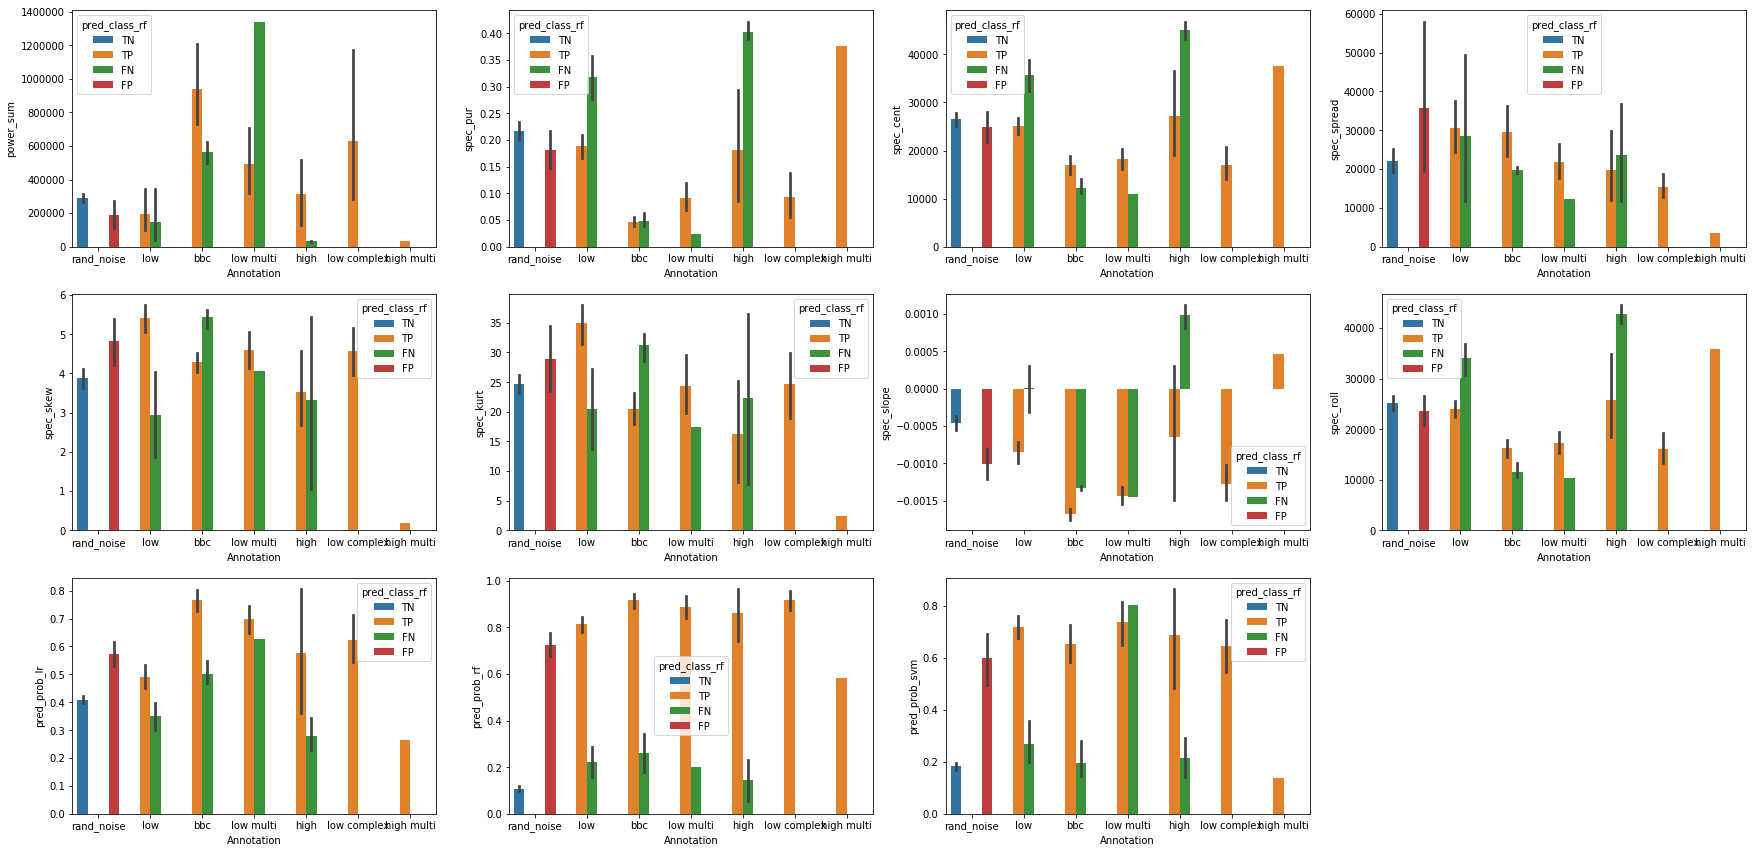

In [0]:
#viz of feature vs. pred group
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_prob_lr', 'pred_prob_rf',
       'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_rf", data=train)
    i = i + 1

In [0]:
#viz for false negatives (need path for corresponding netcdf files)
netcdf_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/netcdf_files/CPA'
false_neg_unique = train_upsamples[train_upsamples['pred'] == 'FN'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_neg_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_neg_unique.iterrows():
  data = xr.open_dataset(str(netcdf_path + '/' + row['animal_number'] + '_' + row['session'] + '_xr_Dataset.nc'))
    
  data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
  times = data['times'].values
  freqs = data['freq'].values
    
  max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
  #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
  plt.subplot(dim, dim, i)
  xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
  i = i + 1

TypeError: ignored

<Figure size 1080x1080 with 0 Axes>

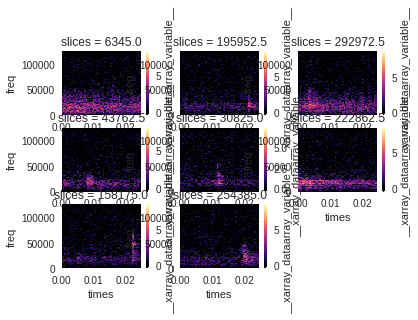

In [0]:
#viz for false positives (need path for corresponding netcdf files)
netcdf_path_pain = '/content/gdrive/Team Drives/USV_eScience_Incubator/Data/netcdf_files/Pain'
false_pos_unique = train_upsamples[train_upsamples['pred'] == 'FP'].drop_duplicates()
dim = dim = np.int(np.ceil(np.sqrt(false_pos_unique.shape[0])))
i = 1
plt.figure(figsize=(dim*5,dim*5))
for index, row in false_pos_unique.iterrows():
    data = xr.open_dataset(str(netcdf_path_pain + '/' + row['session'] + '-' + row['animal_number'] + '-Pre_xr_Dataset.nc'))
    
    data_slice = data['__xarray_dataarray_variable__'].sel(slices=row['time_stamp'])
    times = data['times'].values
    freqs = data['freq'].values
    
    max_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).max(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    #min_value = np.log(data.sel(slices=slice(67.5, 5.999625e+05)).min(xr.ALL_DIMS)['__xarray_dataarray_variable__'].values)
    
    plt.subplot(dim, dim, i)
    xr.ufuncs.log(data_slice).plot(cmap='magma', vmin=0, vmax = max_value*.7)
    
    i = i + 1

In [0]:
#once you have decided on the model and hyperparameters, fit the model using the train data
rf_cv.fit(train_features_scaled, train_class) 
svm_cv.fit(train_features_scaled, train_class) 

SVC(C=1.0, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=True, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
#test model using test data and theshold of 0.5
print('Random forest test AUC: {}'.format(rf_cv.score(test_features_scaled, test_class)))
test_pred_rf = rf_cv.predict(test_features_scaled)
test_pred_prob_rf = rf_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_rf))
confusion_matrix(test_class, test_pred_rf)


Random forest test AUC: 0.6269430051813472
              precision    recall  f1-score   support

           0       0.47      0.83      0.60        65
           1       0.86      0.52      0.65       128

    accuracy                           0.63       193
   macro avg       0.66      0.68      0.63       193
weighted avg       0.73      0.63      0.63       193



array([[54, 11],
       [61, 67]])

In [0]:
#test model using test data and theshold of 0.5
print('SVM test AUC: {}'.format(svm_cv.score(test_features_scaled, test_class)))
test_pred_svm = svm_cv.predict(test_features_scaled)
test_pred_prob_svm = svm_cv.predict_proba(test_features_scaled)
print(classification_report(test_class, test_pred_svm))
confusion_matrix(test_class, test_pred_svm)

SVM test AUC: 0.772020725388601
              precision    recall  f1-score   support

           0       0.61      0.88      0.72        65
           1       0.92      0.72      0.81       128

    accuracy                           0.77       193
   macro avg       0.77      0.80      0.76       193
weighted avg       0.82      0.77      0.78       193



array([[57,  8],
       [36, 92]])

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_8features_rf_full_5noise.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(rf_cv, file)

In [0]:
#pickel model to save for later use
save_path = '/content/gdrive/Shared drives/USV_eScience_Incubator/Data/pickled_models/'


pkl_filename = str(save_path + "trained_pickle_model_8features_svm_full_5noise.pkl")  
with open(pkl_filename, 'wb') as file:  
    pickle.dump(svm_cv, file)

In [0]:
#create new column for model pred porb
test['pred_prob_rf'] = test_pred_prob_rf[:,1]
test['class_rf'] = test_pred_rf
test['pred_prob_svm'] = test_pred_prob_svm[:,1]
test['class_svm'] = test_pred_svm

#create a predictions column for subesquent viz of TN, TP, FN, FP
model_name = 'class_rf'
test = conf_mat_column(test, model_name)
model_name = 'class_svm'
test = conf_mat_column(test, model_name)
test.head()

,Unnamed: 0,Annotation,animal_number,exp,power_sum,session,spec_cent,spec_kurt,spec_pur,spec_roll,spec_skew,spec_slope,spec_spread,time_stamp,class,pred_prob_rf,class_rf,pred_prob_svm,class_svm,pred_class_rf,pred_class_svm
417,92,rand_noise,542,cFos,127302.000,CPApost,39192.143914,55.141255,0.245938,37232.536718,7.305238,-0.000915,164498.928875,90382.5,0,0.529208,1,0.182660,0,FP,TN
571,246,rand_noise,649,PETr1,26597.285,CPApost,16873.874806,6.987402,0.038465,16030.181065,2.620231,-0.001989,18352.307627,33952.5,0,0.200000,0,0.772238,1,TN,FP
278,278,bbc,624,round2,541887.250,CPApost,11489.336861,33.540626,0.044343,10914.870018,5.615024,-0.001363,19024.756765,307800.0,1,0.021412,0,0.104593,0,FN,FN
237,134,rand_noise,553,cFos,38938.016,neutral,26933.710800,2.432538,0.294063,25587.025260,0.580131,-0.000012,1476.671436,270877.5,0,0.000000,0,0.089281,0,TN,TN
60,60,low multi,542,cFos,512213.720,CPApost,17210.077399,44.797510,0.037782,16349.573529,6.468597,-0.001987,71007.161302,469597.5,1,0.999533,1,0.912378,1,TP,TP


In [0]:
test.groupby('Annotation')['pred_class_svm'].value_counts()

Annotation   pred_class_svm
bbc          TP                 27
             FN                 15
high         TP                 10
             FN                  4
high multi   TP                  1
low          TP                 37
             FN                 12
low complex  TP                  6
             FN                  1
low multi    TP                 14
             FN                  1
rand_noise   TN                294
             FP                 29
Name: pred_class_svm, dtype: int64

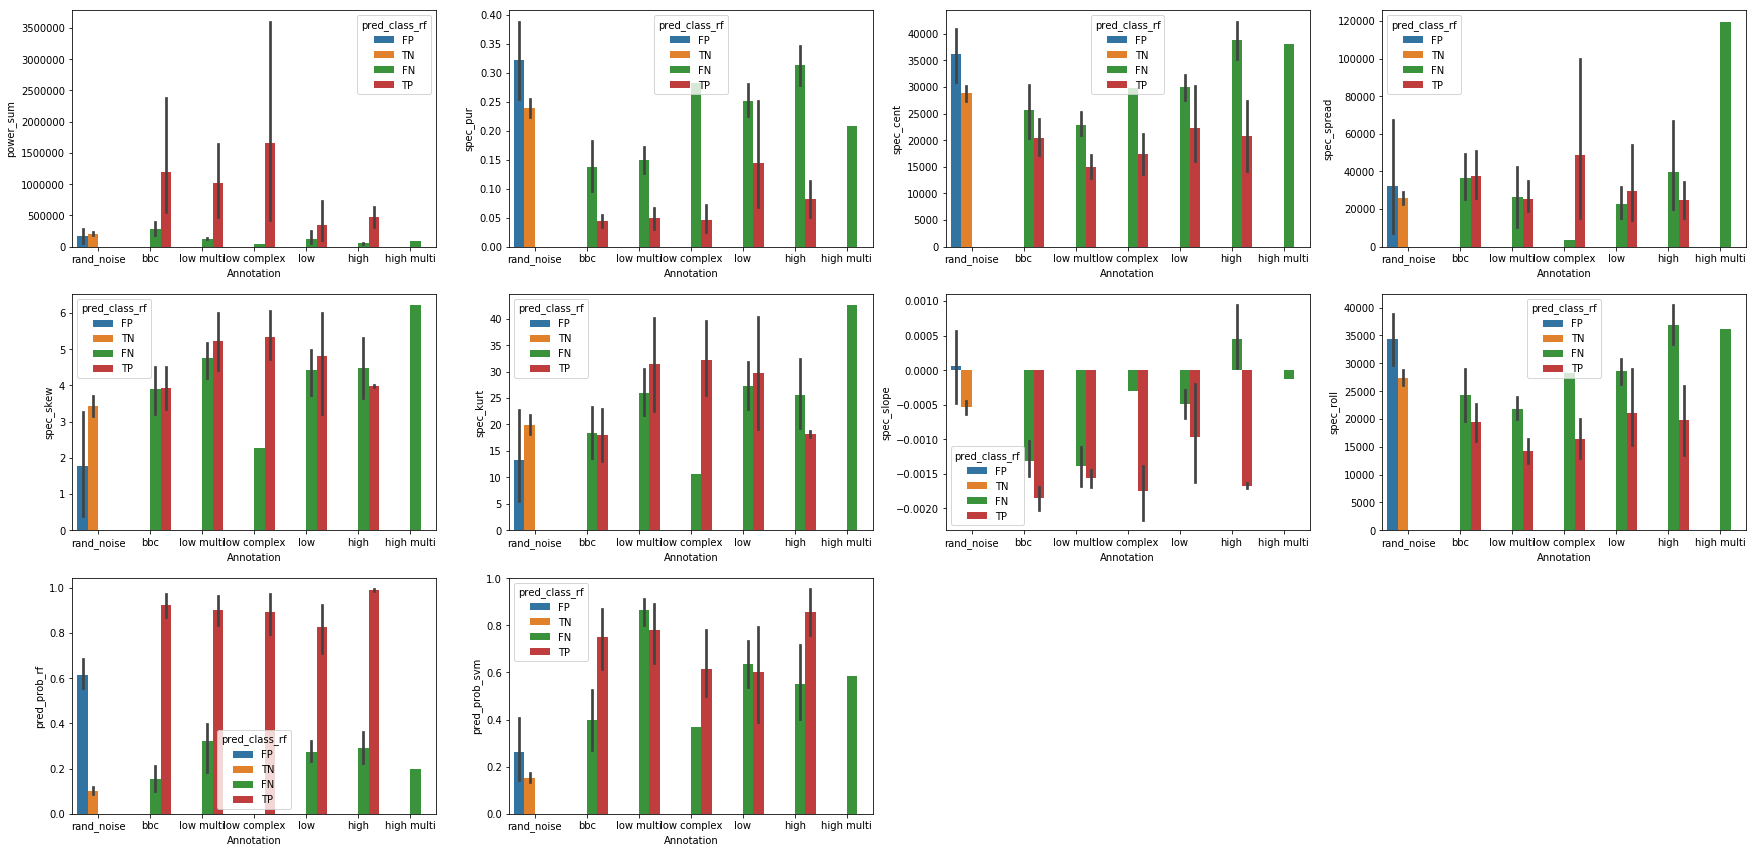

In [0]:
#viz of feature vs. pred group
feat_col = ['power_sum', 'spec_pur', 'spec_cent', 'spec_spread', 'spec_skew',
       'spec_kurt', 'spec_slope', 'spec_roll', 'pred_prob_rf',
       'pred_prob_svm']

i=1
plt.figure(figsize=(30,20))
for name in feat_col:
    plt.subplot(4, 4, i)
    sns.barplot(x="Annotation", y=name, hue="pred_class_rf", data=test)
    i = i + 1

In [0]:
%%time
# This function can take a long to run
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2,  perplexity=50.0, n_iter=5000)
tsne_features = tsne.fit_transform(train_features_scaled)

CPU times: user 18.8 s, sys: 192 ms, total: 19 s
Wall time: 19 s


In [0]:
print(tsne_features.shape)
tsne_df = pd.DataFrame(data = tsne_features, columns = ['tsne_0', 'tsne_1'], index = train['Unnamed: 0'])
tsne_df['exp'] = train['exp'].values
tsne_df['session'] = train['session'].values
tsne_df['Annotation'] = train['Annotation'].values
tsne_df['label'] = train['class'].values
tsne_df.head()

(1052, 2)


,tsne_0,tsne_1,exp,session,Annotation,label
Unnamed: 0,,,,,,
218,-32.010361,8.179417,PETr1,CPApost,low,1
641,14.935540,-16.768137,round2,CPApost,rand_noise,0
473,7.419995,-20.449055,round2,CPApost,rand_noise,0
266,-33.183811,21.492817,PETr1,CPApost,rand_noise,0
53,16.919182,-2.533430,cFos,CPApost,high,1


Text(0.5, 1.0, 'Projection of the data on 2 components + ground truth labels')

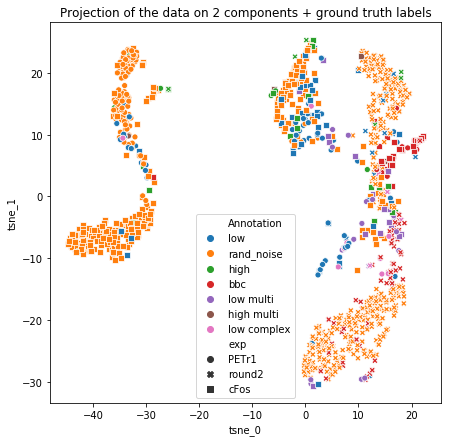

In [0]:
plt.figure(figsize=(7,7))
sns.scatterplot(x = 'tsne_0', y = 'tsne_1', hue = 'Annotation', style="exp", data = tsne_df)
plt.title("Projection of the data on 2 components + ground truth labels")

In [0]:
#generate a 'groups' variable to use with stratified kfold

groups = train['Unnamed: 0'].values

group_k_fold = GroupKFold(n_splits=3)
cv = list(group_k_fold.split(train_features_scaled, train_class, groups))

In [0]:


#upsample minority class (can skip this step if sufficient annotated samples)
majority_class = 'rand_noise'
train_maj = train[train['Annotation'] == majority_class]
train_min = train[train['Annotation'] != majority_class]

train_min_upsamples = resample(train_min, replace=True, n_samples = len(train_maj), random_state = 123)

train_upsamples = pd.concat([train_min_upsamples, train_maj])

print(train_upsamples['Annotation'].value_counts())

train_upsamples.head()

rand_noise     752
low            265
bbc            250
high           104
low multi       80
low complex     44
high multi       9
Name: Annotation, dtype: int64


,Unnamed: 0,Annotation,animal_number,exp,power_sum,session,spec_cent,spec_kurt,spec_pur,spec_roll,spec_skew,spec_slope,spec_spread,time_stamp,class
207,207,low,655,PETr1,383289.440,CPApost,12842.280395,24.192373,0.049716,12200.166376,4.925240,-0.001415,21571.634065,516487.5,1
134,134,low,650,PETr1,118569.840,CPApost,16876.781167,52.082686,0.124803,16032.942109,7.106225,-0.000841,23776.973115,29745.0,1
211,211,low,656,PETr1,42974.860,CPApost,29811.928137,16.092696,0.305364,28321.331730,3.049634,0.000028,3763.859101,6547.5,1
197,197,low complex,655,PETr1,31161.066,CPApost,40678.100525,1.214409,0.413460,38644.195499,-0.138391,0.000750,3981.936708,280260.0,1
43,43,high multi,556,cFos,102098.210,neutral,32622.975486,3.145158,0.200015,30991.826712,1.713068,-0.001008,9715.957517,87840.0,1
